In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel("Model_test_MKB.xlsx", sheet_name="Datasets")
print(df.shape)
print(df["Comeback (0,1)"].value_counts())

(968, 20)
Comeback (0,1)
0    817
1    151
Name: count, dtype: int64


In [ ]:
columns_to_drop = ['KvK', 'Handelsnaam', 'Contactpersoon WP']
df = df.drop(columns=columns_to_drop)

In [ ]:
target = "Comeback (0,1)"
X = df.drop(columns=[target])
y = df[target]

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype(str)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', SimpleImputer(strategy='median'), numeric_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Status', 'Challenge Type',
                                                   'Vak 1', 'Language',
                                                   'Duration', 'Academic Year',
                                                   'Student Time Investment',
                                                   'Company Time Investment',
                                                   'Project_Starting_Date(YYYY_MM)',
                                                   'Regulier/Multidisciplinair',
                                                   'Kennisinstelling',
                                                   'Opleidingsniveau',
                                                   'Industry', 'Location',
                                                   '# of followers']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['# of FTE'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

====== Confusion Matrix ======
[[149  17]
 [  4  24]]

====== Classification Report ======
Accuracy: 0.892
ROC-AUC: 0.932

Class 0 (No Return):
  Precision: 0.97
  Recall:    0.90
  F1-Score:  0.93

Class 1 (Return):
  Precision: 0.59
  Recall:    0.86
  F1-Score:  0.70

Macro Avg:
  Precision: 0.78
  Recall:    0.88
  F1-Score:  0.81

Weighted Avg:
  Precision: 0.92
  Recall:    0.89
  F1-Score:  0.90


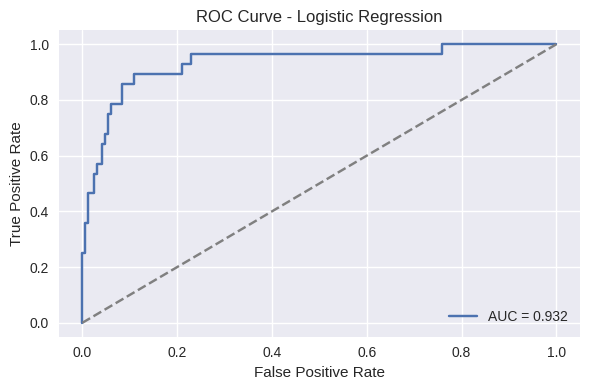

In [ ]:
# Predict probabilities and labels at threshold = 0.4
y_prob = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.4).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print("====== Confusion Matrix ======")
print(conf_matrix)

print("\n====== Classification Report ======")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print("\nClass 0 (No Return):")
print(f"  Precision: {report['0']['precision']:.2f}")
print(f"  Recall:    {report['0']['recall']:.2f}")
print(f"  F1-Score:  {report['0']['f1-score']:.2f}")

print("\nClass 1 (Return):")
print(f"  Precision: {report['1']['precision']:.2f}")
print(f"  Recall:    {report['1']['recall']:.2f}")
print(f"  F1-Score:  {report['1']['f1-score']:.2f}")

print("\nMacro Avg:")
print(f"  Precision: {report['macro avg']['precision']:.2f}")
print(f"  Recall:    {report['macro avg']['recall']:.2f}")
print(f"  F1-Score:  {report['macro avg']['f1-score']:.2f}")

print("\nWeighted Avg:")
print(f"  Precision: {report['weighted avg']['precision']:.2f}")
print(f"  Recall:    {report['weighted avg']['recall']:.2f}")
print(f"  F1-Score:  {report['weighted avg']['f1-score']:.2f}")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


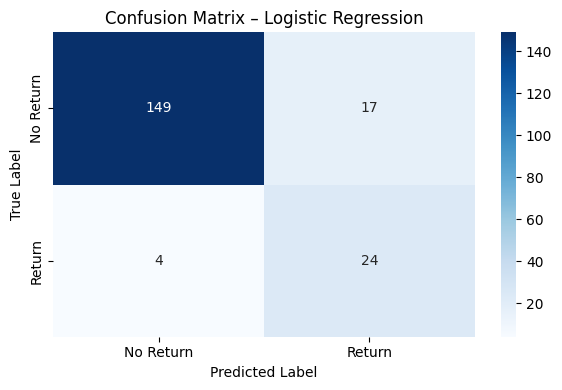

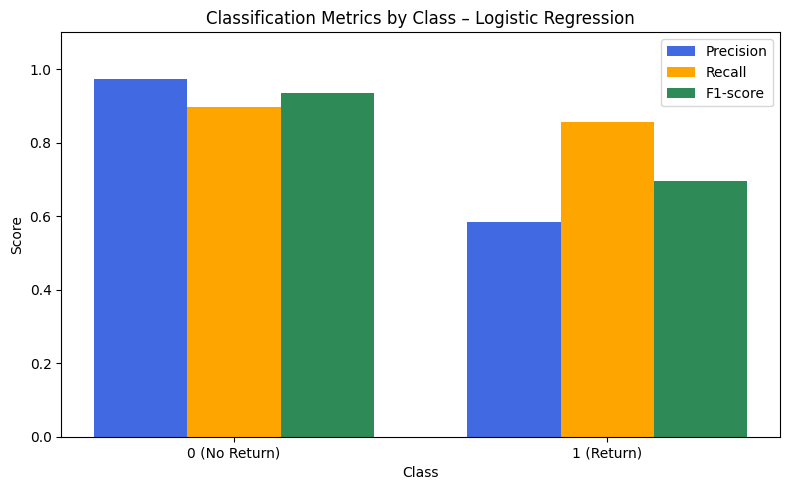

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Return", "Return"],
            yticklabels=["No Return", "Return"])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

metrics = ["precision", "recall", "f1-score"]
classes = ["0 (No Return)", "1 (Return)"]
scores = {
    metric: [report["0"][metric], report["1"][metric]]
    for metric in metrics
}

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
index = np.arange(len(classes))

for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, scores[metric], width=bar_width,
           label=metric.capitalize(),
           color=["royalblue", "orange", "seagreen"][i])

ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_title("Classification Metrics by Class – Logistic Regression")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = list(encoder.get_feature_names_out(categorical_cols)) + numeric_cols

coefficients = pipeline.named_steps['classifier'].coef_[0]

import pandas as pd
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()

top_features = coef_df.sort_values(by="Abs_Coefficient", ascending=False).head(15)
print(top_features)

                                     Feature  Coefficient  Abs_Coefficient
0              Status_1. Challenge ingediend     2.044117         2.044117
449                        # of followers_29     2.022935         2.022935
3                       Status_4. Geen Match    -1.944699         1.944699
533                        # of followers_74     1.883153         1.883153
227                             Industry_nan    -1.692717         1.692717
525                       # of followers_693     1.489999         1.489999
509                       # of followers_598     1.419753         1.419753
2                Status_3. Definitieve match     1.398469         1.398469
401                       # of followers_151     1.394705         1.394705
339         Location_The Hague, Zuid Holland     1.394705         1.394705
16        Vak 1_AI Masterclass Rabo - mrt 25     1.360001         1.360001
190  Project_Starting_Date(YYYY_MM)_2025-Mar     1.342564         1.342564
517                      

/tmp/ipython-input-33-230388236.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Coefficient", y="Feature", data=top_lollipop,


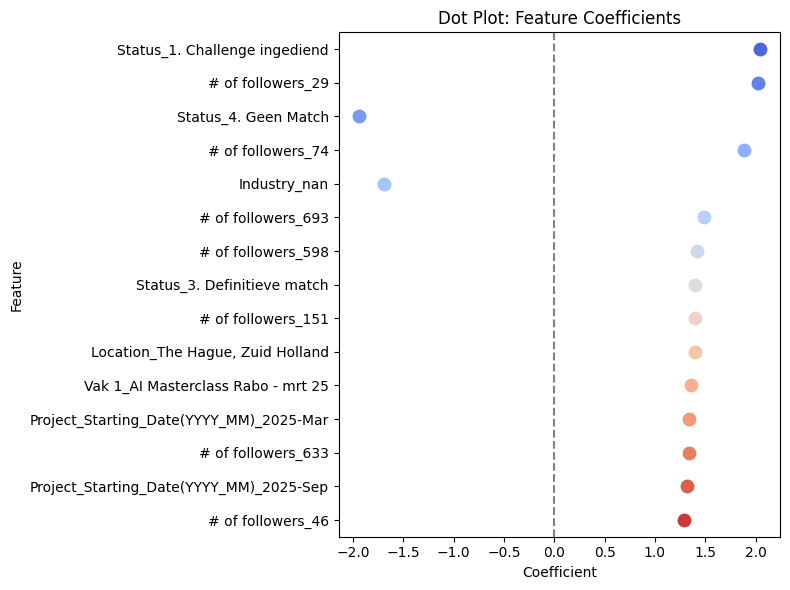

In [ ]:
plt.figure(figsize=(8, 6))
sns.stripplot(x="Coefficient", y="Feature", data=top_lollipop,
              palette="coolwarm", size=10)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Dot Plot: Feature Coefficients")
plt.tight_layout()
plt.show()